# Crank-Nicolson Scheme

Copyright (C) 2010-2020 Luke Olson<br>
Copyright (C) 2020 Andreas Kloeckner

<details>
<summary>MIT License</summary>
Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
THE SOFTWARE.
</details>

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

## Problem Description

Here you will set up the problem for
$$ u_t - c u_x = 0$$
with periodic BC on the interval [0,1]

In [3]:
c = 1.0
T = 1.0 / c # end time

## Set up the Grid
- `dx` will be the grid spacing in the $x$-direction  
- `x` will be the grid coordinates  
- `xx` will be really fine grid coordinates

In [4]:
nx = 82
x = np.linspace(0, 1, nx, endpoint=False)
dx = x[1] - x[0]
xx = np.linspace(0, 1, 1000, endpoint=False)

Now define an initial condition:

In [5]:
def square_wave(x):
    u = np.zeros(x.shape)
    u[np.intersect1d(np.where(x>0.4), np.where(x<0.6))] = 1.0
    return u

def sine_wave(x):
    return np.sin(3.14159265359*x)  

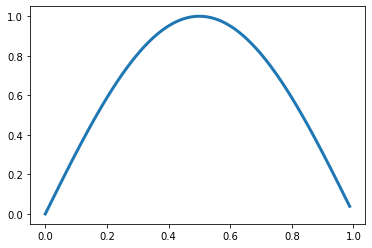

In [6]:
g = sine_wave
plt.plot(x, g(x), lw=3, clip_on=False)

## Setting the Time Step

Now we need a time step.  Let
$$ \Delta t = \Delta x \frac{\lambda}{c}$$
So we need a parameter $\lambda$

<span style="color:red">What happens when $\lambda>1.0$?</span>

In [7]:
lmbda = 1.03
dt = dx * lmbda / c
nt = int(T/dt)
print('T = %g' % T)
print('tsteps = %d' % nt)
print('    dx = %g' % dx)
print('    dt = %g' % dt)
print('lambda = %g' % lmbda)

T = 1
tsteps = 79
    dx = 0.0121951
    dt = 0.012561
lambda = 1.03


## Crank-Nicolson

$$ u_t - c u_x = 0$$  
$$ u_t = c u_x $$  
$$ \frac{u_i^{n+1} - u_i^n}{\Delta t} = c \frac{1}{2}(\frac{u_{i+1}^n - u_{i-1}^n}{2 \Delta x} + \frac{u_{i+1}^{n+1} - u_{i-1}^{n+1}}{2 \Delta x})$$  
$$ u_i^{n+1} = u_i^n + \frac{c \Delta t}{4 \Delta x}(u_{i+1}^n - u_{i-1}^n + u_{i+1}^{n+1} - u_{i-1}^{n+1})$$

This is an implicit scheme, so we'll need to solve a system. Move all $u^{n+1}$ terms to left side and let $\lambda = \frac{c \Delta t}{\Delta x}$:

$$ -\frac{\lambda}{4} u_{i+1}^{n+1} + u_i^{n+1} + \frac{\lambda}{4} u_{i-1}^{n+1} = \frac{\lambda}{4} u_{i+1}^n + u_i^n - \frac{\lambda}{4} u_{i-1}^n$$

Set up a system of equations:

$$M_1 u^{n+1} = M_2 u^n$$

Where $M_1 =$
\begin{bmatrix}
    1 & \frac{\lambda}{4} & 0 & \dots & 0 & -\frac{\lambda}{4} \\
    -\frac{\lambda}{4} & 1 & \frac{\lambda}{4} & & & 0 \\
    0 & -\frac{\lambda}{4} & \ddots & \ddots & & \vdots \\
    \vdots & & \ddots & & & 0 \\
    0 & & & & & \frac{\lambda}{4} \\
    \frac{\lambda}{4} & 0 & \dots & 0 & -\frac{\lambda}{4} & 1
\end{bmatrix}

The elements in the top right and bottom left corners enforce periodic boundary conditions.

And $M_2 = M_1^T$.

## Implementation

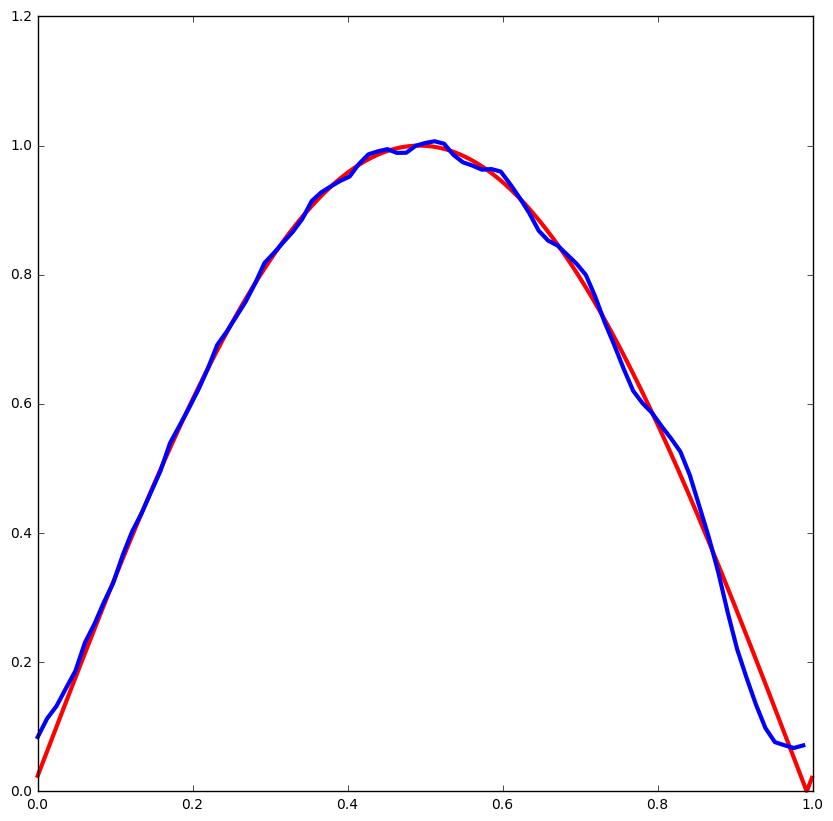

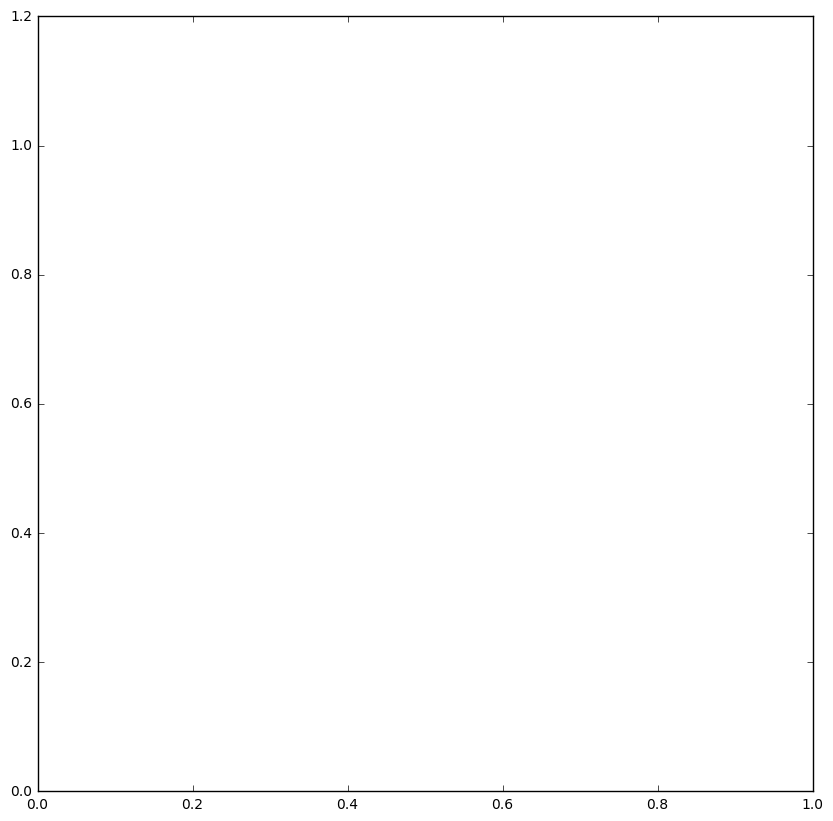

In [7]:
import time
from IPython.display import clear_output, display
plotit = True
u = g(x)

# create M1:
lmbda_array = np.ones(nx-1)*[lmbda/4.0]
m1 = np.diag(-1*lmbda_array, -1) + np.identity(nx) + np.diag(lmbda_array, 1)

# enforce periodic boundary conditions
m1[0][nx-1] = -lmbda/4.0
m1[nx-1][0] = lmbda/4.0
    
# create M2:
m2 = m1.transpose()

if plotit:
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_title('u vs x')

for n in range(0, nt):
   
    u = np.linalg.solve(m1, np.dot(m2,u))
    uex = g((xx - c * (n+1) * dt) % 1.0)
    if plotit:
        ax.plot(xx, uex, 'r-', lw=3, clip_on=False)
        ax.plot(x, u, '-', lw=3, clip_on=False)
        clear_output(True)
        display(fig)
        ax.cla()

## Check the Error

In [8]:
n=nt-1
uex = g((x - c * (n+1) * dt) % 1.0)
error = u - uex
l2err = np.sqrt(dx * np.sum(error**2))
print(l2err)

0.0224103701666
